## Summary

This notebook is designed to predict the numerical value of images of hand-written numerals.

The steps are
 1. Load the mnist test data set
 2. Provision the training compute instances
 3. Train the model
 4. Validate the model with known numbers
 5. Test the model with unknown numbers

In [3]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='kb-sagemaker'

### Data ingestion

Load the mnist data set from [here](http://yann.lecun.com/exdb/mnist/).

In [4]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 772 ms, sys: 300 ms, total: 1.07 s
Wall time: 7.09 s


### Sample data


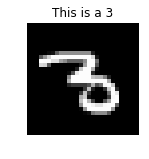

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Train the kmeans model
1. Provision two compute-optimized servers with kmeans containers
2. Train the model with mnsit data

In [6]:
from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_project3/data'.format(bucket)
output_location = 's3://{}/kmeans_project3/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

training data will be uploaded to: s3://kb-sagemaker/kmeans_highlevel_project3/data
training artifacts will be uploaded to: s3://kb-sagemaker/kmeans_project3/output


In [7]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-04-12-19-34-16-768


..........................................................
Docker entrypoint called with argument(s): train
[04/12/2018 19:38:57 INFO 140219198781248] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[04/12/2018 19:38:57 INFO 140219198781248] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'mini_batch_size': u'5000', u'k': u'10', u'force_dense': u'True'}
[04/12/2018 19:38:57 INFO 140219198781248] Fi

===== Job Complete =====
Billable seconds: 317
CPU times: user 8.02 s, sys: 0 ns, total: 8.02 s
Wall time: 5min 49s


## Set up hosting for the model

NOTE: Only run this once, or if you have deleted the endpoint.  This is the code that provisions the API endpoint
to be used for inferences and should stay up and running all the time

In [6]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

RuntimeError: Estimator has not been fit yet.

## Validate the model for use
Make an inference for a single known observation

In [8]:
result = kmeans_predictor.predict(train_set[0][30:31])
print(result)

NameError: name 'kmeans_predictor' is not defined

OK, a single prediction works.

Let's do a whole batch and see how well the clustering works.

In [8]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 538 ms





Cluster 0:


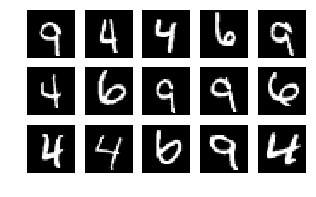




Cluster 1:


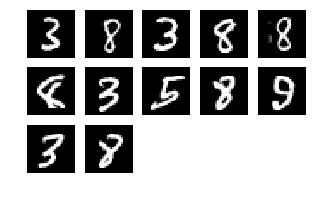




Cluster 2:


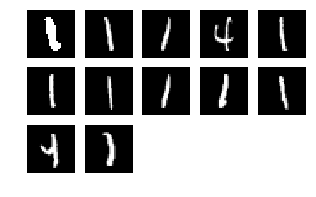




Cluster 3:


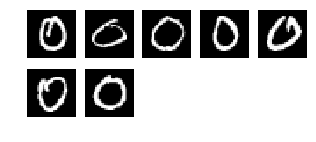




Cluster 4:


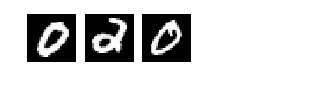




Cluster 5:


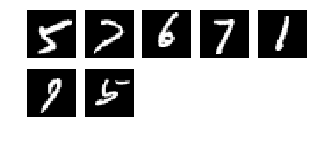




Cluster 6:


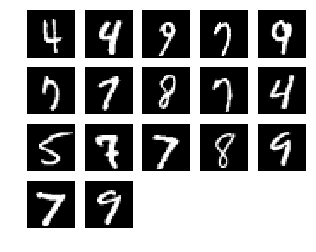




Cluster 7:


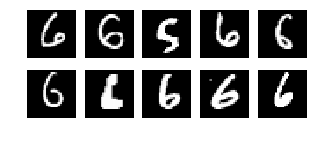




Cluster 8:


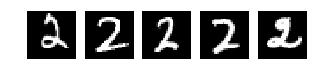




Cluster 9:


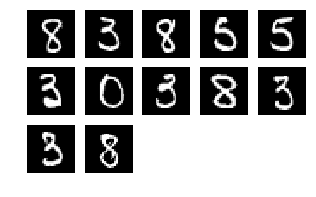

In [9]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### The bottom line

K-Means clustering is not the best algorithm for image analysis problems, but we do see pretty reasonable clusters being built.

### (Optional) Delete the Endpoint
If you're ready to be done with this notebook, make sure run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [10]:
print(kmeans_predictor.endpoint)

kmeans-2018-04-09-01-39-22-457
